# Import

In this section we try do perform some statistical test to check which model we can use

In [0]:
%pip install prophet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import requests
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import ( col, to_date, lag, avg, stddev, log, when, current_date, date_sub, add_months, expr, row_number, dayofweek, lit)
from pyspark.sql.types import StructType, StructField, DateType, DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import pandas_udf, PandasUDFType


In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

From the dataset we decided to keep only the last 5 years just for test purposes

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

# Models Selection


- in order to test the models we decided only to use a 5 year window 
- For all the model we are using a 30 days test window, this does not mean that the models will make a prediction for each day as the weekends are not taken into our data

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

original_df = spark_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
num_rows = original_df.count()
num_cols = len(original_df.columns)
print(num_rows, num_cols)
original_df.printSchema()

# take only the last 5 years to reduce the amount of data (just for testing)
cutt_point = -60
cutoff = add_months(current_date(), cutt_point)
df_cutt = original_df.filter(col("date") >= cutoff)


df_cutt = df_cutt.cache()
print(f"Filtered (last 5y): {df_cutt.count()} rows")
df_cutt.show(5, truncate=False)

ts_df = df_cutt

## Auxilary functions

we decidd to create some feature but we decided to use only features that would be availble at the time of the prediction
- because we are only predicting "close" we decided not to use the coulmns "open" and "volume" because although we have the data for in order to test our algorithms the data won't be available for actual prediction

In [0]:
def make_features(df):
    w = Window.orderBy("date")
    w_roll5 = Window.orderBy("date").rowsBetween(-5, -1)
    w_roll30 = Window.orderBy("date").rowsBetween(-30, -1)
    return (
        df
        .withColumn("close_lag1",lag("close", 1).over(w))
        .withColumn("close_lag2",lag("close", 2).over(w))
        .withColumn("close_lag3",lag("close", 3).over(w))
        .withColumn("close_lag4",lag("close", 4).over(w))
        .withColumn("close_lag5",lag("close", 5).over(w))
        .withColumn("ma5",avg("close").over(w_roll5))
        .withColumn("ma30",avg("close").over(w_roll30))
        .withColumn("dow",dayofweek("date"))
        .na.drop()
    )

## Model using GBTR

we first create:
- the feature in order to see how would our model me fitted only on train data 
- a set of dates that would be used for testing 
- a vector assemble that would be used in the pipeline

In [0]:
feat_df = make_features(ts_df)

all_dates = [r.date for r in feat_df.select("date").distinct().orderBy("date").collect()]
test_dates = all_dates[-30:]
train_feat_df = feat_df.filter(~col("date").isin(test_dates))
# create a vector for the feature that are going to be used for this model
assembler = VectorAssembler(
    inputCols=["close_lag1","close_lag2","close_lag3","close_lag4","close_lag4","close_lag5","ma5","ma30","dow"],
    outputCol="features"
)
gbt = GBTRegressor(labelCol="close", featuresCol="features", maxIter=50)


### Model Run

we first run the model on the overall train_data to see how it fits

Train RMSE = 10.1673
Train Relative RMSE  = 0.0561


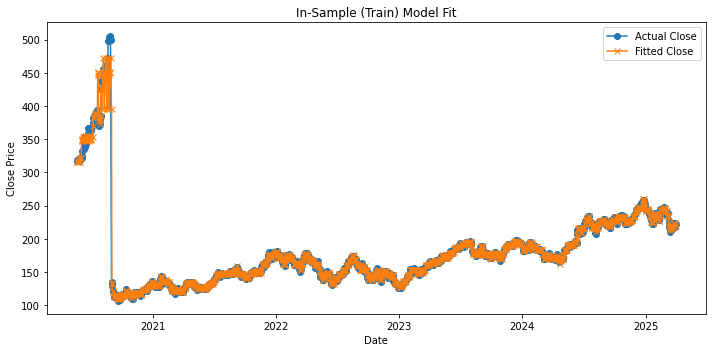

In [0]:
train_vec = assembler.transform(train_feat_df)
model = gbt.fit(train_vec)

preds_train = (
    model
      .transform(train_vec)
      .select(
          col("date"),
          col("prediction"),
          col("close").alias("actual")
      )
)

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse = evaluator.evaluate(preds_train)
mean_actual = preds_train.select(avg("actual")).first()[0]
train_rrmse = train_rmse / mean_actual

print(f"Train RMSE = {train_rmse:.4f}")
print(f"Train Relative RMSE  = {train_rrmse:.4f}")

train_pdf = preds_train.toPandas()
train_pdf["date"] = pd.to_datetime(train_pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(train_pdf["date"], train_pdf["actual"],     marker='o', label="Actual Close")
plt.plot(train_pdf["date"], train_pdf["prediction"], marker='x', label="Fitted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("In-Sample (Train) Model Fit")
plt.legend()
plt.tight_layout()
plt.show()

In our evaluation we use a **rolling, one-day-ahead** forecasting strategy:

1. **Train on historical data up to the forecast date**  
   At each step, we fit the model on all available data **before** the day we want to predict. This mimics how you would train in production—only past information is ever used.

2. **Predict the next day’s close price**  
   We generate a single forecast for “tomorrow” (the next trading day) using that freshly trained model.

3. **Feed the prediction back in**  
   Instead of using the true close for the next step (which would leak future information), we inject our own forecast into the historical series. Those forecasts then become part of the training data for the following day’s model fit.

This procedure guarantees that **no future actual prices** are ever used when making each prediction—exactly as would occur in a real-world deployment. It also means we can only compute performance metrics (RMSE, RRMSE, etc.) **once** the true values are eventually observed (e.g. end-of-day actual closes).

In [0]:
history = ts_df.select("date", "close")


Test RMSE = 20.2745
Test Relative RMSE = 0.0967)


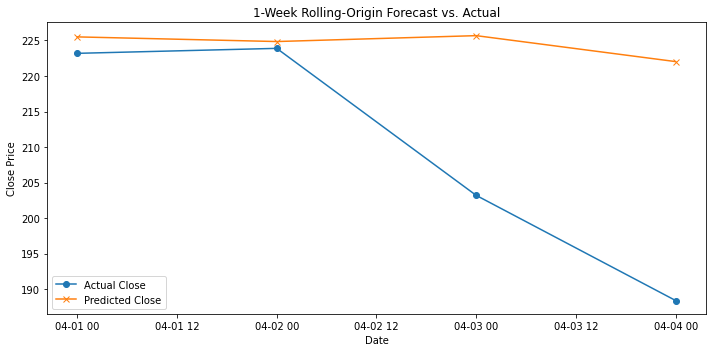

In [0]:
results = []
history = ts_df.select("date", "close")

for d in test_dates:
    # 1) assemble the history up to and including d
    hist = history.filter(col("date") <= d)

    # 2) compute features on that full history
    hist_feat = make_features(hist)

    # 3) split train vs. this one-day test row
    train_vec = assembler.transform(hist_feat.filter(col("date") < d))
    test_vec  = assembler.transform(hist_feat.filter(col("date") == d))

    # 4) fit and predict
    model = gbt.fit(train_vec)
    pred = model.transform(test_vec).select("prediction").first()[0]
    actual = test_vec.select("close").first()[0]

    results.append((d, float(pred), float(actual)))
    
    # create the new row in order to make the next prediction based of the prediction made
    new_row = spark.createDataFrame([Row(date=d, close=pred)])
    history = history.union(new_row)

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="predicted",
    metricName="rmse"
)
# create a spark dataframe from the result and calculate the RMSE using it and RRMSE
result_df = spark.createDataFrame(results, ["date", "predicted", "actual"])
rmse = evaluator.evaluate(result_df)
mean_actual = result_df.select(avg("actual")).first()[0]
rel_rmse = rmse / mean_actual

print(f"Test RMSE = {rmse:.4f}")
print(f"Test Relative RMSE = {rel_rmse:.4f})")

# plot the results
pdf = result_df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf["date"], pdf["actual"],    marker='o', label="Actual Close")
plt.plot(pdf["date"], pdf["predicted"], marker='x', label="Predicted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("1-Week Rolling-Origin Forecast vs. Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
results

Out[37]: [(datetime.date(2025, 4, 1), 225.50561906835128, 223.19),
 (datetime.date(2025, 4, 2), 224.85130628940257, 223.89),
 (datetime.date(2025, 4, 3), 225.6811998385287, 203.19),
 (datetime.date(2025, 4, 4), 222.02641598467767, 188.38)]

## Model using Prophet (pandas UDFs)

In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType, col, lit, avg
from pyspark.sql.types import StructType, StructField, DateType, DoubleType
from prophet import Prophet


train RMSE            = 30.9163
train Relative RMSE   = 0.1702


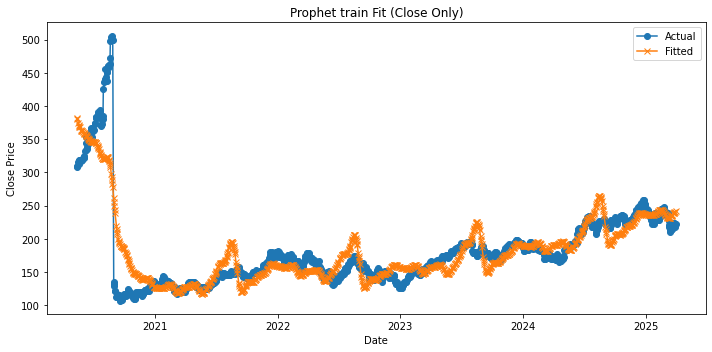

In [0]:
schema_train_ = StructType([
    StructField("date",       DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",     DoubleType())
])

# pandas UDF: fit Prophet on full training set, predict on that same set
@pandas_udf(schema_train_, PandasUDFType.GROUPED_MAP)
def prophet_train_ample(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    pdf["y"]  = pdf["close"]
    
    # fit on all training rows
    m = Prophet()
    m.fit(pdf[["ds","y"]])
    
    # predict in‐sample
    fc = m.predict(pdf[["ds"]])  # returns ds, yhat, etc.
    return pd.DataFrame({
        "date":       fc["ds"].dt.date,
        "prediction": fc["yhat"],
        "actual":     pdf["y"].values
    })

# 1c) Apply UDF to all rows *except* the test dates
train_df = ts_df.filter(~col("date").isin(test_dates)).withColumn("grp", lit(1))
train_preds = train_df.groupBy("grp").apply(prophet_train_ample).drop("grp")

# 1d) Compute in‐sample RMSE & RRMSE
evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse     = evaluator.evaluate(train_preds)
mean_train_act = train_preds.select(avg("actual")).first()[0]
train_rrmse    = train_rmse / mean_train_act

print(f"train RMSE            = {train_rmse:.4f}")
print(f"train Relative RMSE   = {train_rrmse:.4f}")

# 1e) Plot in‐sample actual vs. fitted
pdf_train_ = train_preds.toPandas()
pdf_train_["date"] = pd.to_datetime(pdf_train_["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf_train_["date"], pdf_train_["actual"],    marker='o', label="Actual")
plt.plot(pdf_train_["date"], pdf_train_["prediction"],marker='x', label="Fitted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet train Fit (Close Only)")
plt.legend()
plt.tight_layout()
plt.show()

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:100: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


test Rolling RMSE            = 42.8816
test Rolling Relative RMSE   = 0.2124


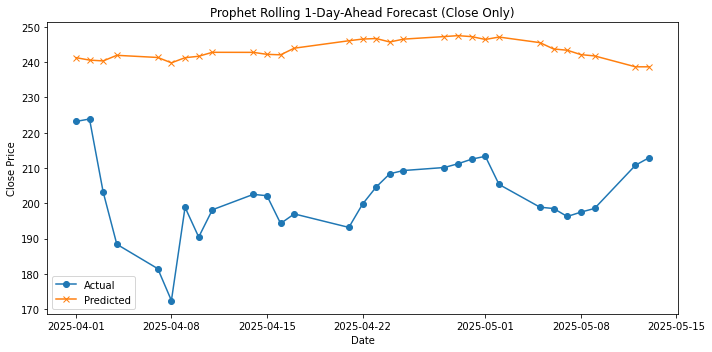

In [0]:
schema_test = StructType([
    StructField("date",       DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",     DoubleType())
])

# 2b) pandas UDF: iterative, 1-day-ahead forecasts feeding predictions back in
@pandas_udf(schema_test, PandasUDFType.GROUPED_MAP)
def prophet_rolling(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    
    # initialize series of y-values (actual)
    y_series = dict(zip(pdf["ds"], pdf["close"]))
    preds = []
    
    for dt in test_dates:
        dt_ts = pd.to_datetime(dt)
        train = pd.DataFrame({
            "ds": list(y_series.keys()),
            "y":  list(y_series.values())
        })
        train = train[train["ds"] < dt_ts]
        
        m = Prophet()
        m.fit(train)
        yhat = m.predict(pd.DataFrame({"ds":[dt_ts]}))["yhat"].iloc[0]
        
        actual = y_series[dt_ts]
        preds.append({
            "date":       dt_ts.date(),
            "prediction": float(yhat),
            "actual":     float(actual)
        })
        
        # feed prediction back in
        y_series[dt_ts] = yhat
    
    return pd.DataFrame(preds)

roll_df    = ts_df.withColumn("grp", lit(1))
roll_preds = roll_df.groupBy("grp").apply(prophet_rolling).drop("grp")

roll_df = ts_df.withColumn("grp", lit(1))
roll_preds = roll_df.groupBy("grp").apply(prophet_rolling).drop("grp")

rmse_test     = evaluator.evaluate(roll_preds)
mean_test_act = roll_preds.select(avg("actual")).first()[0]
rrmse_test    = rmse_test / mean_test_act

print(f"test Rolling RMSE            = {rmse_test:.4f}")
print(f"test Rolling Relative RMSE   = {rrmse_test:.4f}")

pdf_test = roll_preds.toPandas()
pdf_test["date"] = pd.to_datetime(pdf_test["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf_test["date"], pdf_test["actual"],    marker='o', label="Actual")
plt.plot(pdf_test["date"], pdf_test["prediction"],marker='x', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet Rolling 1-Day-Ahead Forecast (Close Only)")
plt.legend()
plt.tight_layout()
plt.show()

# Actual Prediction

In [0]:
import datetime
from pyspark.sql import Row

# 1) Fit on the entire history once
full_feat    = make_features(ts_df)
full_vec     = assembler.transform(full_feat)
model_full   = gbt.fit(full_vec)

# 2) Pull the last 30 closes into a Python list (most recent first)
last30 = (
    ts_df
    .orderBy(col("date").desc())
    .limit(30)
    .select("close")
    .rdd.flatMap(lambda r: r)
    .collect()
)

# 3) Find your “starting” date
all_dates = sorted(r.date for r in ts_df.select("date").distinct().collect())
next_date = all_dates[-1] + datetime.timedelta(days=1)

preds = []
closes = last30.copy()   # will append each forecast

for _ in range(30):
    # a) compute lags & MAs from `closes`
    lags = closes[:5]                        # [lag1, lag2, …]
    ma5  = sum(lags) / 5
    ma30 = sum(closes) / len(closes)
    dow  = (next_date.weekday() + 1) % 7 + 1 # Spark’s dayofweek mapping

    # b) build the single‐row features
    future_row = Row(
        date       = next_date,
        close_lag1 = float(lags[0]),
        close_lag2 = float(lags[1]),
        close_lag3 = float(lags[2]),
        close_lag4 = float(lags[3]),
        close_lag5 = float(lags[4]),
        ma5        = float(ma5),
        ma30       = float(ma30),
        dow        = int(dow)
    )
    future_df = spark.createDataFrame([future_row])
    future_vec = assembler.transform(future_df)

    # c) predict
    pred = model_full.transform(future_vec).select("prediction").first()[0]

    # record
    preds.append((next_date, float(pred)))

    # feed back
    closes.insert(0, pred)     # new ‘lag1’ for the next iteration
    if len(closes) > 30:       # keep only the last 30
        closes.pop()
    next_date += datetime.timedelta(days=1)

# wrap up
pred_df = spark.createDataFrame(preds, ["date","forecast"])
pred_df.show(30)

+----------+------------------+
|      date|          forecast|
+----------+------------------+
|2025-05-14|214.17595697963802|
|2025-05-15| 213.9632341890576|
|2025-05-16|212.74863638742514|
|2025-05-17| 214.8399055583746|
|2025-05-18| 216.6580926099726|
|2025-05-19| 216.6580926099726|
|2025-05-20|217.00403671482277|
|2025-05-21|216.68126333385194|
|2025-05-22|215.01751205294866|
|2025-05-23| 214.8399055583746|
|2025-05-24| 214.8399055583746|
|2025-05-25| 216.6580926099726|
|2025-05-26| 216.6580926099726|
|2025-05-27|217.00403671482277|
|2025-05-28|216.68126333385194|
|2025-05-29|215.01751205294866|
|2025-05-30| 214.8399055583746|
|2025-05-31| 214.8399055583746|
|2025-06-01| 216.6580926099726|
|2025-06-02| 216.6580926099726|
|2025-06-03|217.00403671482277|
|2025-06-04|216.68126333385194|
|2025-06-05|215.01751205294866|
|2025-06-06| 214.8399055583746|
|2025-06-07| 214.8399055583746|
|2025-06-08| 216.6580926099726|
|2025-06-09| 216.6580926099726|
|2025-06-10|217.00403671482277|
|2025-06